# Crazy Idea Numero #128 - Timer for Water Heater
We recently switched to Portland General Electrics TOD (Time of Day) Rate system, where electric rates change throughout the day three times, to charge more when overall grid demand is high (everyone gets home from work), and less, when demand is low. In this system Electricity is the most expensive between 5-9 (about 40c /kWh) and the cheapest at night (about 8c/kWh). Our motivation to switch was two-fold - there is an opportunity to switch some loads to off peak hours and save some money, and secondly, it is good for the environment - Lowering peak loads allows for a higher percentage of grid needs to be met by renewables. 

It got me down a track, wondering if we could shift all of our electicity usage off the grid between 5-9pm, using a battery system. After a few quotes through Energy Trust of Oregon, the average 13.5kWh battery system cost 10k after incentives. This ended up being around a 10 year payback. This would be great, but it left me wondering - Is there something simpler I could do? What about the "thermal battery" I already have in my home (aka, my water heater)? Could I take advantage of this? 

The idea this led me to is this: What would happen if I shut off my water heater during peak hours? Would my showers go cold? Or does my tank have enough storage to keep the hot water flowing through my normal usage? Our water heater is a traditional electrical water heater and has a 44 Gallon Tank.

Thus began my little water heater science project. The key questions I needed to answer are:
1. How much money could I save by doing this? What would be the payback period?
2. How long could I shut off our water heater without running out of hot water in 99% of scenarios? What about 99.9%? 
3. Is it worth it? 

Fortunately, I had SENSE installed in 2016, and it has been dutifully keeping tracking of my water heater electricity usage by the hour, and allows me to download it to look at my last years data. 

So Lets take a look!

## 1. Money Money Money

In [4]:
# Setting up
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image


In [5]:
# Lets import the first text file
#filepath = os.path('Users/aglick/Documents/Vibration Analysis Cargo Bike/')
file = 'Water heater1-hour data from Jan 1, 2024 to Dec 31, 2024.csv'
#df = pd.read_csv(file,header = 1, index_col=0)# Read in CSV file
df = pd.read_csv(file,header = 1)# Read in CSV file


In [6]:
# Convert the 'DateTime' column to a pandas datetime object
dft = df
dft['DateTime'] = pd.to_datetime(dft['DateTime'])

# Select and clean up the relevant columns
cleaned_data = dft[['DateTime', 'kWh']].copy()

# Ensure the data is sorted by DateTime
cleaned_data.sort_values('DateTime', inplace=True)

# Set the DateTime column as the index
cleaned_data.set_index('DateTime', inplace=True)

# Create a complete hourly range from the start to the end of the dataset
full_range = pd.date_range(start=cleaned_data.index.min(), 
                           end=cleaned_data.index.max(), 
                           freq='H')

# Reindex the data to include all timestamps in the range, filling missing values with 0
cleaned_data = cleaned_data.reindex(full_range, fill_value=0)


In [7]:
def assign_rate(hour):
    if 0 <= hour < 8:
        return .0908  # Midnight to 8am
    elif 8 <= hour < 17:
        return .1699  # 8am to 5pm
    elif 17 <= hour < 21:
        return .4389  # 5pm to 9pm
    else:
        return .0908  # 9pm to midnight

# Add an 'Hour' column for easier rate assignment
cleaned_data['Hour'] = cleaned_data.index.hour

# Apply the rate function to the 'Hour' column
cleaned_data['Rate_Dollars_Per_kWh'] = cleaned_data['Hour'].apply(assign_rate)

# Calculate the cost by multiplying 'kWh' by 'Rate'
cleaned_data['Cost_Dollars'] = cleaned_data['kWh'] * cleaned_data['Rate_Dollars_Per_kWh']

Lets plot it, to see if the data looks reasonable

Total Yearly Usage =  2665.411 kWh


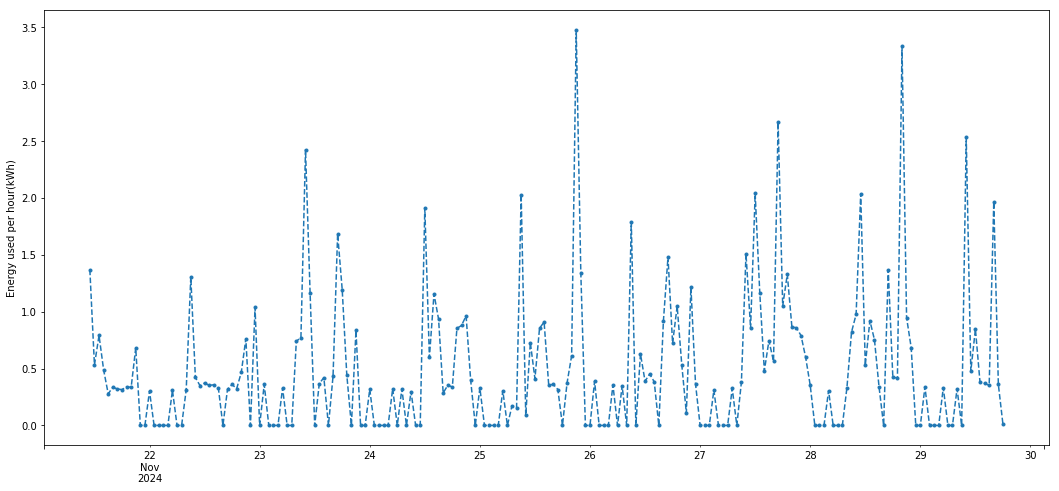

In [8]:
#Plot it
ax2 = cleaned_data['kWh'].tail(200).plot(figsize = (18,8),marker = '.',linestyle = '--')
ax2.set_ylabel('Energy used per hour(kWh)')
print('Total Yearly Usage = ',cleaned_data['kWh'].sum(), 'kWh')
plt.show()

This seems feasible - The water heater tag estimates 3500kWh for a typical household, and we probably are a bit stingier than most, and December is not included

Now  for the first Question - How much money could we save annually if we pulled it off?

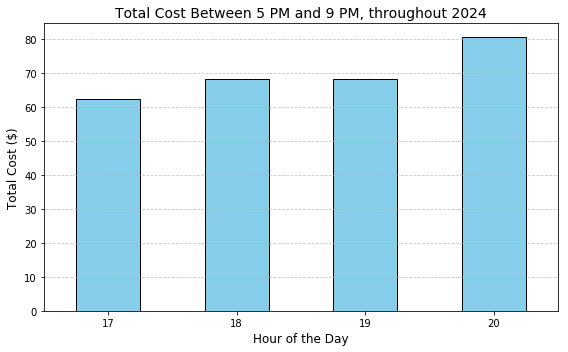

Total Yearly Cost for Hot Water = $ 565.17 under PGEs Time of Day Rate System


In [9]:

# Filter data for the specified hours (5 PM to 9 PM)
filtered_data = cleaned_data.between_time('17:00', '20:00')

# Group by hour to sum the costs
hourly_cost = filtered_data.groupby(filtered_data.index.hour)['Cost_Dollars'].sum()

# Plot the data
plt.figure(figsize=(8, 5))
hourly_cost.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Total Cost Between 5 PM and 9 PM, throughout 2024', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Total Cost ($)', fontsize=12)
plt.xticks(ticks=range(len(hourly_cost.index)), labels=hourly_cost.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
print('Total Yearly Cost for Hot Water = $',round(cleaned_data['Cost_Dollars'].sum(),2), 'under PGEs Time of Day Rate System')

This all seems reasonable. The Estimate sticker on my Water heater reads that I should expect about "$424' each year in cost.

Looks like if we could just shut off the water heater just one hour a day, between 8-9pm, we would save about \\$80 dollars over the year. If we could shut it off 2 hours,pm between 7-9, about \\$148, and 6-9pm, about \\$216. That's \\$18$/$month

What would the payback period be for this little project? Water heater timers (like this [GE one](https://www.amazon.com/gp/product/B07TVKSDD4?ie=UTF8&tag=pnavtable-20&camp=1789&linkCode=xm2&creativeASIN=B00FBOXDT0&th=1)) and parts combined are about 80-100$, so a less than 6 month payback. But for me, \\$200 per year might be worth it, especially with the added environmental benefit.

One small note for the energy transition nerds out there:  on a higher level, this could actually damage the energy transition if it made folks think that running out of hot water is like after the energy transition. But, if kept to just a few nerds who wont be able to install home batteries for a few years, probably a net gain. 

## 2. Will my showers go cold?
So it appears there would be a small payback for this, but at what cost? Will I be forced to take cold showers everynight? More importantly, will my wife be forced to take cold showes everynight?

Lets start by looking at the distribution of usage over the year - How many kWh do I used between 5-9pm, and then using that to figure out how many gallons of hot water will be accessible.


<Figure size 720x432 with 0 Axes>

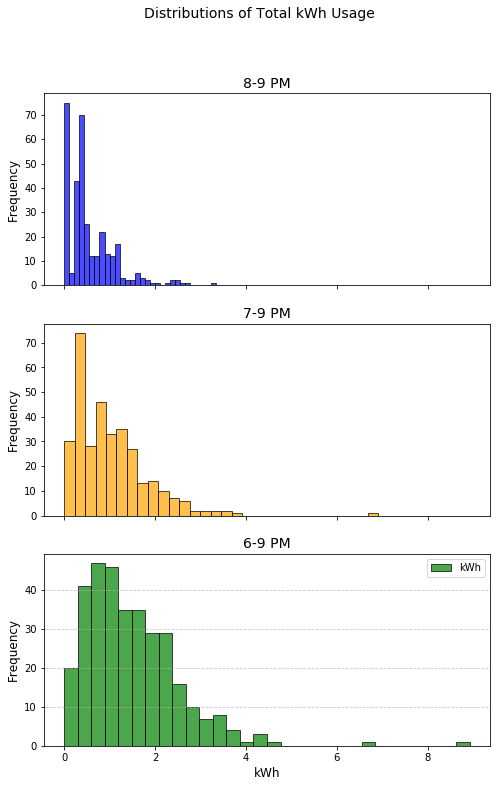

In [12]:

# Filter data for the specified hours
kwh_8pm = cleaned_data[cleaned_data.index.hour == 20]['kWh']  # 8 PM
kwh_7_8pm = cleaned_data[(cleaned_data.index.hour >= 19) & (cleaned_data.index.hour <= 20)]['kWh']  # 7 PM and 8 PM
kwh_6_8pm = cleaned_data[(cleaned_data.index.hour >= 18) & (cleaned_data.index.hour <= 20)]['kWh']  # 6 PM to 8 PM

# Calculate total 'kWh' for each hour range
total_kwh_8pm = kwh_8pm.resample('D').sum()
total_kwh_7_8pm = kwh_7_8pm.resample('D').sum()
total_kwh_6_8pm = kwh_6_8pm.resample('D').sum()

# Plot the distributions
plt.figure(figsize=(10, 6))

# Create subplots for the histograms
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Distribution for 8 PM
axes[0].hist(total_kwh_8pm, bins=30, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('8-9 PM', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=12)

# Distribution for 7-8 PM
axes[1].hist(total_kwh_7_8pm, bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1].set_title('7-9 PM', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=12)

# Distribution for 6-8 PM
axes[2].hist(total_kwh_6_8pm, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('6-9 PM', fontsize=14)
axes[2].set_xlabel('Total kWh', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)

# Add labels and title
plt.suptitle('Distributions of Total kWh Usage', fontsize=14)
plt.xlabel('kWh', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Ok! so it looks like these charts tell us that most days, our usage lies between 0-3kWh depending on the time range we are looking at. On the higher end, it looks like 4kWh would be more than we would ever expect to use in the 8-9pm hour, and more than all but a few days of the 6-9pm hour. But we want to know with a bit more certainty, so lets look at the percentiles. As a reference, 1 day a year would correspond to a percentile of 99.7% 

In [25]:
quantile_1day_8_9pm = total_kwh_8pm.quantile(0.997)
quantile_2day_8_9pm = total_kwh_8pm.quantile(0.994)
quantile_1day_7_9pm = total_kwh_7_8pm.quantile(0.997)
quantile_2day_7_9pm = total_kwh_7_8pm.quantile(0.994)
quantile_1day_6_9pm = total_kwh_6_8pm.quantile(0.997)
quantile_2day_6_9pm = total_kwh_6_8pm.quantile(0.994)

print('The 99.4% and 99.7% for 8-9PM would be: ',round(quantile_2day_8_9pm,2), 'and',round(quantile_1day_8_9pm,2),'kWh')
print('The 99.4% and 99.7% for 7-9PM would be: ',round(quantile_2day_7_9pm,2), 'and',round(quantile_1day_7_9pm,2),'kWh')
print('The 99.4% and 99.7% for 6-9PM would be: ',round(quantile_2day_6_9pm,2), 'and',round(quantile_1day_6_9pm,2),'kWh')

The 99.4% and 99.7% for 8-9PM would be:  2.57 and 2.71 kWh
The 99.4% and 99.7% for 7-9PM would be:  3.52 and 3.76 kWh
The 99.4% and 99.7% for 6-9PM would be:  4.54 and 6.75 kWh


So there we have it! If we shut off the water heater from 6-9pm, we would need 4.54kWh stored up in the hot water heater to meet the demand for all but two days a year.

Buut, what exactly is a kWh? Even us energy nerds do not go around noting our usage in kWh, so lets convert it to something we can think more tanglibly about - Gallons of hot water, say hot enough to take a shower (lets use 110 deg F). 


From heat transfer theory, we know that the heat $Q$ is equal to the mass of a heated liquid $m$ times the specific heat $c$ and the temperature difference $\Delta T$.
$$
Q = m \cdot c \cdot \Delta T
$$
$$
\frac{Q}{c \cdot \Delta T} = m 
$$

And then we can convert the mass of water to volume (Gallons)

In [ ]:
#How many kWh can our tank hold?
Gal_of_120degWater = 44

In [40]:
#Set up specific heat and temperature Delta
T_incoming = 10 #C
#T_WH = 48.88 #C Heating setting of our water heater 119.9F
T_WH = 43.3 #C Heating setting of our water heater 110F
T_delta = T_WH- T_incoming
c_H20 = 4.184 #J/(g*K)
CvsnFctr_kWh_to_Joule = 3.6*10**6 #1kWh = 3.6*10^6J
c_H20_kWh = c_H20/CvsnFctr_kWh_to_Joule #kWh/(g*K)



Q = np.array([quantile_2day_8_9pm,quantile_2day_7_9pm,quantile_2day_6_9pm])
Mass_of_Water = Q/(c_H20_kWh*T_delta)/1000 #kg
print(np.round(Mass_of_Water,2),'kg Water for 1hr, 2hr and 3hrs of a turned off water heater')
#How many gallons?
#25kg = 25L
Liters_to_Gallons = 3.4
Gallons_of110DegWater = np.round(Mass_of_Water/Liters_to_Gallons,3)
print(Gallons_of110DegWater,'Gallons Water for 1hr, 2hr and 3hrs of a turned off water heater')

[ 66.38  90.92 117.42] kg Water for 1hr, 2hr and 3hrs of a turned off water heater
[19.524 26.742 34.535] Gallons Water for 1hr, 2hr and 3hrs of a turned off water heater


So, we would need to store 4.54kWh to shut off from 6-9, and meet demand all but 2 days a year. This says that would correspond to that is 34.535 Gallons of water at 110F. Our tank is 44 Gallons, and the temp setting is 120F! So this indicates that even for the 3 hour shut off, the hot water heater can in theory store and provide that energy.

However, the distribution of hot water in the tank, and the mixing that occurs as you use up the hot water is key. While theory might be able to dig into this, better to just give this a test.

So, in the interest of science, I flipped the breaker to the water heate, turned on our upstairs shower and took a luxuriously long shower. 34 minutes to be exact. I do not know the exact temperature of the water, but I estimate it at 110F. 

32 minutes! at 1.3GPM, that is 41.6 Gallons of hot water before I noticed it start to get cold. That is almost the whole tank! that means the stratification in the tank effectively separates the hot and cold water for most of the discharge of the tank. 

Comparing that 41.6 Gallons to our estimated margins for 1 day a year, there is a chance that we will never have cold water, and save over 200\$ per year!

So in 90% of cases, the amount used in each hour is less than 1.2kWh. We should double check to make sure that for the combination